In [2]:
# import gensim
import collections
import random
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.contrib.tensorboard.plugins import projector

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances_chunked, pairwise_distances
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

from tqdm import tnrange, tqdm_notebook
import scipy
from scipy.spatial.distance import cosine, pdist

import altair as alt
from altair import datum

from itertools import compress

import time


In [36]:
!pwd

/Users/ellieking/Documents/content-similarity/google-universal-encoder


### Set-up and get data

As this notebook uses data derived from the [govuk-taxonomy-supervised-learning repo](https://github.com/alphagov/govuk-taxonomy-supervised-learning), we clone that. Given you are likely to perform this for a given date, we suggest you create a dir with the date of the format `dd-mm-yy` within the data folder of the aforementioned repo and point to the data folder therein as the DATADIR. 

For example:

```
/Users/adalovelace/Documents/govuk-taxonomy-supervised-learning/data/11-02-19
```

In [3]:
DATADIR = os.getenv("DATADIR")

Import vectors with same index as labelled. This may require some modification to match your filename.

In [4]:
embedded_sentences = np.load(np.load('embedded_clean_content'+os.path.basename(DATADIR)+'.npy'))


The Google Universal Sentence Encoder model takes a word, sentence or a paragraph as input and outputs a 512-dimensional vector.

In [6]:
# rows, cols
embedded_sentences.shape


(305703, 512)

In [5]:
labelled = pd.read_csv(
    os.path.join(DATADIR, 'labelled.csv.gz'),
    compression='gzip',
    low_memory=False)


In [6]:
labelled.shape

(305703, 19)

In [10]:
labelled.head(3)

base_path  \
0  /government/publications/list-of-psychologists...   
1  /government/news/charity-commission-names-furt...   
2  /government/publications/trust-and-confidence-...   

                             content_id  \
0  04a0cc0d-0b9f-45ad-bf57-7c54cbab9df9   
1  5fa49c52-7631-11e4-a3cb-005056011aef   
2  d0341424-12a1-4b4c-9045-2e74ba17f2d5   

                                         description  document_type  \
0  list of english speaking psychologists and psy...       guidance   
1      regulator increases transparency of its work.  press_release   
2  independent research into trust and confidence...       research   

              first_published_at locale primary_publishing_organisation  \
0  2017-07-21T16:42:00.000+00:00     en   Foreign & Commonwealth Office   
1  2014-06-04T23:00:00.000+00:00     en          The Charity Commission   
2  2015-06-25T07:00:00.000+00:00     en          The Charity Commission   

  publishing_app                                              title  \
0      whitehall  chile - list of psychologists and psychiatrist...   
1      whitehall  charity commission names further charities und...   
2      whitehall  trust and confidence in the charity commission...   

                                                body  \
0  prepared by british embassy/consulate santiago...   
1  the charity commission has today named further...   
2  the charity commission commissioned populus to...   

                                       combined_text  \
0  chile - list of psychologists and psychiatrist...   
1  charity commission names further charities und...   
2  trust and confidence in the charity commission...   

                               taxon_id  \
0  668cd623-c7a8-4159-9575-90caac36d4b4   
1  668cd623-c7a8-4159-9575-90caac36d4b4   
2  668cd623-c7a8-4159-9575-90caac36d4b4   

                              taxon_base_path             taxon_name  \
0  /society-and-culture/community-and-society  Community and society   
1  /society-and-culture/community-and-society  Community and society   
2  /society-and-culture/community-and-society  Community and society   

           level1taxon            level2taxon level3taxon level4taxon  \
0  Society and culture  Community and society         NaN         NaN   
1  Society and culture  Community and society         NaN         NaN   
2  Society and culture  Community and society         NaN         NaN   

  level5taxon  
0         NaN  
1         NaN  
2         NaN

In [11]:
# use list to print entire string, overcoming notebook defaults
list(labelled['combined_text'].head(1))

['chile - list of psychologists and psychiatrists 2017 list of english speaking psychologists and psychiatrists in santiago. prepared by british embassy/consulate santiago chile. list of psychologists and psychiatrists 2017 pdf 412kb 8 pages']

New variable, called level, to categorise taxon by level in the tree

In [7]:
labelled = labelled.assign(level=np.where(labelled.level5taxon.notnull(), 5, 0))
labelled.loc[labelled['level4taxon'].notnull() & labelled['level5taxon'].isnull(
), 'level'] = 4
labelled.loc[labelled['level3taxon'].notnull() & labelled['level4taxon'].isnull(
), 'level'] = 3
labelled.loc[labelled['level2taxon'].notnull() & labelled['level3taxon'].isnull(
), 'level'] = 2
labelled.loc[labelled['level1taxon'].notnull() & labelled['level2taxon'].isnull(
), 'level'] = 1


In [13]:
labelled.shape


(305703, 20)

need these dictionaries to get these varaibles into plots later

In [14]:
taxon_id_to_base_path = dict(
    zip(labelled['taxon_id'], labelled['taxon_base_path']))
taxon_id_to_level = dict(zip(labelled['taxon_id'], labelled['level']))
taxon_id_to_level1 = dict(zip(labelled['taxon_id'], labelled['level1taxon']))


need this array to loop through later

In [15]:
taxons = labelled['taxon_id'].unique()


In [16]:
taxons


array(['668cd623-c7a8-4159-9575-90caac36d4b4',
       'd0f1e5a3-c8f4-4780-8678-994f19104b21',
       'f3dcc290-752f-4bbe-b379-9155d919a58d', ...,
       '373e6e1c-d73f-41a7-ac8c-0da991abbedb',
       '66acfe61-6c51-4cd9-90e0-34e47358020c',
       '51522bef-3147-4d85-a4e9-ad3d94743183'], dtype=object)

How many unique pieces of content are there on GOV.UK? 

In [17]:
labelled.content_id.nunique()


208261

Used this brexit variable in some tensorboard visualisations. Kept it here for now but not used in this notebook

In [18]:
labelled['brexit'] = np.where(labelled['level2taxon'] == 'Brexit', 1, 0)


In [19]:
labelled.brexit.value_counts()


0    304477
1      1226
Name: brexit, dtype: int64

# Using vectors for homogeneity score

# Homogeneity scores

For each taxon get a mean cosine distance for all pairs within the taxon

In [25]:
taxon_homogeneity = []
for taxon in tqdm_notebook(taxons):
    taxon_embeddings = embedded_sentences[labelled['taxon_id'] == taxon]
    taxon_size = taxon_embeddings.shape[0]
    mean_cosine_for_taxon = np.mean(
        pairwise_distances(taxon_embeddings, metric='cosine', n_jobs=-1))

    taxon_homogeneity.append([taxon, taxon_size, mean_cosine_for_taxon])


### Create taxon level dataframe with diversity, size and level attributes

In [26]:
taxon_homogeneity_df = pd.DataFrame(
    taxon_homogeneity, columns=['taxon_id', 'taxon_size',
                                'mean_cosine_score']).sort_values(
                                    'mean_cosine_score', ascending=False)
taxon_homogeneity_df['taxon_base_path'] = taxon_homogeneity_df['taxon_id'].map(
    taxon_id_to_base_path)
taxon_homogeneity_df['taxon_level'] = taxon_homogeneity_df['taxon_id'].map(
    taxon_id_to_level)
taxon_homogeneity_df['level1taxon'] = taxon_homogeneity_df['taxon_id'].map(
    taxon_id_to_level1)

taxon_homogeneity_df.shape


(1265, 6)

A couple of binary vairables that may flag taxon quality

In [27]:
taxon_homogeneity_df['fewer_than_or_equal_5items'] = np.where(
    taxon_homogeneity_df['taxon_size'] <= 5, 1, 0)


In [28]:
taxon_homogeneity_df['more_than_0_5_diversity'] = np.where(
    taxon_homogeneity_df['mean_cosine_score'] > 0.5, 1, 0)


In [29]:
taxon_homogeneity_df.head()


taxon_id  taxon_size  mean_cosine_score  \
0    668cd623-c7a8-4159-9575-90caac36d4b4        5166           0.595490   
246  f9e476ef-654d-41ec-97d9-2b6842d4361d         786           0.589025   
48   495afdb6-47be-4df1-8b38-91c8adb1eefc        8136           0.571510   
833  fc5f468f-a3ba-4fde-9c1d-ed2dd17cfd82          31           0.571205   
18   b29cf14b-54c6-402c-a9f0-77218602d1af        2333           0.569644   

                                       taxon_base_path  taxon_level  \
0           /society-and-culture/community-and-society            2   
246            /society-and-culture/sports-and-leisure            2   
48                              /business-and-industry            1   
833  /housing-local-and-community/housing-local-ser...            3   
18               /society-and-culture/arts-and-culture            2   

                      level1taxon  fewer_than_or_equal_5items  \
0             Society and culture                           0   
246           Society and culture                           0   
48          Business and industry                           0   
833  Housing, local and community                           0   
18            Society and culture                           0   

     more_than_0_5_diversity  
0                          1  
246                        1  
48                         1  
833                        1  
18                         1

### For each branch get a summary of the taxon attributes

In [30]:
#mean only
mean_per_level1 = taxon_homogeneity_df[[
    'taxon_size', 'mean_cosine_score', 'level1taxon',
    'fewer_than_or_equal_5items'
]].groupby('level1taxon').mean()


In [31]:
#both mean and sum (to count content in branch)
per_level1 = taxon_homogeneity_df[[
    'taxon_size', 'mean_cosine_score', 'level1taxon',
    'fewer_than_or_equal_5items'
]].groupby('level1taxon').agg(['sum', 'mean'])
per_level1.columns = per_level1.columns.map('_'.join)
per_level1


taxon_size_sum  \
level1taxon                                                     
Business and industry                                   52715   
Corporate information                                     687   
Crime, justice and law                                  34603   
Defence and armed forces                                 9460   
Education, training and skills                          12261   
Entering and staying in the UK                           3126   
Environment                                             30541   
Going and being abroad                                   2724   
Government                                              37151   
Health and social care                                  21965   
Housing, local and community                            10505   
International                                           13938   
Life circumstances                                        299   
Money                                                    9812   
Parenting, childcare and children's services             2212   
Regional and local government                           10210   
Society and culture                                     15790   
Transport                                               29660   
Welfare                                                  3528   
Work                                                     4516   

                                               taxon_size_mean  \
level1taxon                                                      
Business and industry                               560.797872   
Corporate information                               687.000000   
Crime, justice and law                              865.075000   
Defence and armed forces                            350.370370   
Education, training and skills                       80.137255   
Entering and staying in the UK                       91.941176   
Environment                                         215.077465   
Going and being abroad                              544.800000   
Government                                          562.893939   
Health and social care                              309.366197   
Housing, local and community                        244.302326   
International                                       536.076923   
Life circumstances                                   27.181818   
Money                                                50.839378   
Parenting, childcare and children's services         34.562500   
Regional and local government                       340.333333   
Society and culture                                 584.814815   
Transport                                           154.479167   
Welfare                                             252.000000   
Work                                                141.125000   

                                               mean_cosine_score_sum  \
level1taxon                                                            
Business and industry                                      38.928539   
Corporate information                                       0.520828   
Crime, justice and law                                     16.392576   
Defence and armed forces                                    9.193295   
Education, training and skills                             50.673534   
Entering and staying in the UK                             11.620877   
Environment                                                48.619254   
Going and being abroad                                      2.416334   
Government                                                 22.982650   
Health and social care                                     25.262048   
Housing, local and community                               14.053696   
International                                              11.229476   
Life circumstances                                          4.149259   
Money                                                      49.627861   
Parenting, 

### Get the overall diversity of content in the branch (before stuff is sorted into taxons)

In [32]:
branch_homogeneity = []
for branch in tqdm_notebook(labelled.level1taxon.unique()):
    total_cosine_for_branch = np.zeros(1)
    denominator_for_branch = np.zeros(1)
    branch_embeddings = embedded_sentences[labelled['level1taxon'] == branch]
    branch_size = branch_embeddings.shape[0]
    for chunk in pairwise_distances_chunked(
            branch_embeddings, metric='cosine', n_jobs=-1):
        print(chunk.shape)
        total_cosine_for_branch += np.sum(chunk)
        denominator_for_branch += np.prod(chunk.shape)

    mean_cosine_for_branch = np.asscalar(
        total_cosine_for_branch / denominator_for_branch)

    branch_homogeneity.append([branch, branch_size, mean_cosine_for_branch])


(8500, 15790)
(7290, 15790)
(4516, 4516)
(6110, 21965)
(6110, 21965)
(6110, 21965)
(3635, 21965)
(4394, 30541)
(4394, 30541)
(4394, 30541)
(4394, 30541)
(4394, 30541)
(4394, 30541)
(4177, 30541)
(9629, 13938)
(4309, 13938)
(3878, 34603)
(3878, 34603)
(3878, 34603)
(3878, 34603)
(3878, 34603)
(3878, 34603)
(3878, 34603)
(3878, 34603)
(3579, 34603)
(10946, 12261)
(1315, 12261)
(4525, 29660)
(4525, 29660)
(4525, 29660)
(4525, 29660)
(4525, 29660)
(4525, 29660)
(2510, 29660)
(3612, 37151)
(3612, 37151)
(3612, 37151)
(3612, 37151)
(3612, 37151)
(3612, 37151)
(3612, 37151)
(3612, 37151)
(3612, 37151)
(3612, 37151)
(1031, 37151)
(10505, 10505)
(2546, 52715)
(2546, 52715)
(2546, 52715)
(2546, 52715)
(2546, 52715)
(2546, 52715)
(2546, 52715)
(2546, 52715)
(2546, 52715)
(2546, 52715)
(2546, 52715)
(2546, 52715)
(2546, 52715)
(2546, 52715)
(2546, 52715)
(2546, 52715)
(2546, 52715)
(2546, 52715)
(2546, 52715)
(2546, 52715)
(1795, 52715)
(9460, 9460)
(9812, 9812)
(3528, 3528)
(10210, 10210)
(2724, 

In [34]:
branch_homogeneity_df = pd.DataFrame(
    branch_homogeneity, columns=['branch', 'branch_size',
                                 'mean_cosine_score']).sort_values(
                                     'mean_cosine_score', ascending=False)
branch_homogeneity_df.shape


(20, 3)

did some thinking about standardising the size to create diversity score weighted by size of group of content (branch/taxon). 
It never fully materialised but kept in here for now

In [35]:
mean_per_level1['weighted_score_taxon'] = mean_per_level1[
    'mean_cosine_score'] / mean_per_level1['taxon_size'] * 1000


In [36]:
branch_homogeneity_df['min_max_branch_size'] = (
    branch_homogeneity_df['branch_size'] -
    branch_homogeneity_df['branch_size'].min()) / (
        branch_homogeneity_df['branch_size'].max() -
        branch_homogeneity_df['branch_size'].min())


In [37]:
branch_homogeneity_df['weighted_score'] = branch_homogeneity_df[
    'mean_cosine_score'] / branch_homogeneity_df['min_max_branch_size']


In [38]:
branch_by_ave_taxon = pd.merge(mean_per_level1, branch_homogeneity_df, left_on='level1taxon', right_on='branch')

In [39]:
branch_by_ave_taxon['branch_to_taxon_ratio'] = branch_by_ave_taxon['mean_cosine_score_y']/branch_by_ave_taxon['mean_cosine_score_x']

## Describe patterns (descriptive analysis)

### Taxon size by diversity

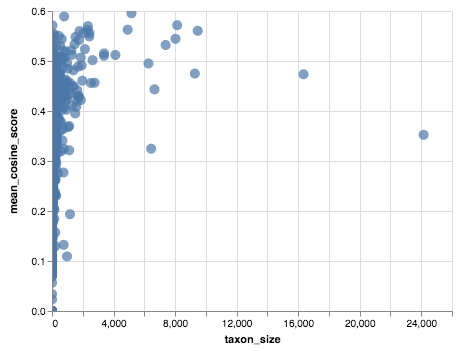

In [40]:
alt.Chart(taxon_homogeneity_df).mark_circle(size=60).encode(
    x='taxon_size',
    y='mean_cosine_score',
    tooltip=['taxon_base_path'],
    size=alt.value(100),
).interactive()


Taxon size is too skewed - transform with log

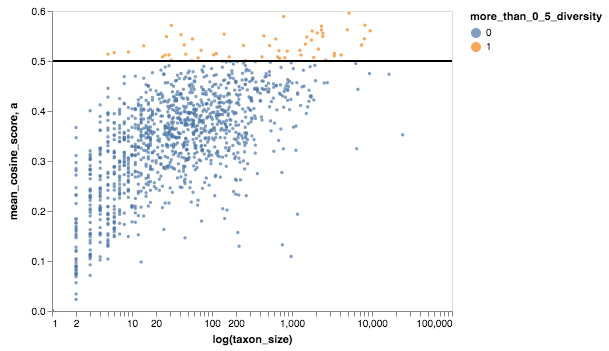

In [41]:
points = alt.Chart(taxon_homogeneity_df).mark_circle(size=60).encode(
    alt.X('taxon_size:Q', 
                    scale=alt.Scale(type='log'),
                  axis=alt.Axis(grid=False,
                               title='log(taxon_size)')),
    alt.Y('mean_cosine_score:Q',
                  axis=alt.Axis(grid=False)),
    tooltip=['taxon_base_path'], 
    color='more_than_0_5_diversity:N',
    size=alt.value(10),
).interactive()

line = alt.Chart().mark_rule().encode(
    y='a:Q'
)

alt.layer(
    points, line,
    data=taxon_homogeneity_df
).transform_calculate(
    a="0.5"
)

This identifies taxons which are too diverse (>0.5) and probably need attention

Looking at them below in more detail (coloured by depth in tree)

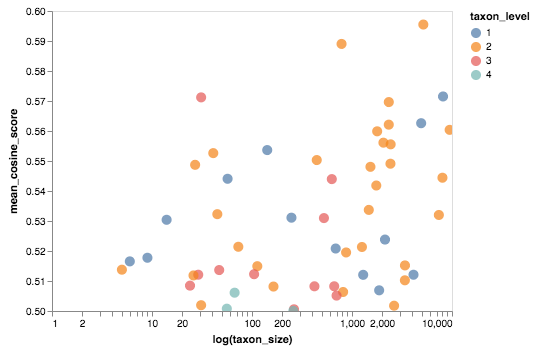

In [42]:
alt.Chart(taxon_homogeneity_df).mark_circle(size=60).encode(
    alt.X(
        'taxon_size:Q',
        scale=alt.Scale(type='log'),
        axis=alt.Axis(grid=False, title='log(taxon_size)')),
    alt.Y(
        'mean_cosine_score:Q',
        axis=alt.Axis(grid=False),
        scale=alt.Scale(zero=False)),
    tooltip=['taxon_base_path'],
    color='taxon_level:N',
    size=alt.value(100),
).interactive().transform_filter(datum.mean_cosine_score > 0.5)


Get a list of diverse smaller taxons

In [43]:
list(taxon_homogeneity_df[
    (taxon_homogeneity_df['mean_cosine_score'] > 0.5) &
    (taxon_homogeneity_df['taxon_size'] < 300)].taxon_base_path)


['/housing-local-and-community/housing-local-services-safety-environment',
 '/government/all',
 '/crime-justice-and-law/rights',
 '/government/democracy',
 '/international',
 '/employment/working',
 '/society-and-culture',
 '/going-and-being-abroad',
 '/regional-and-local-government/local-councils',
 '/regional-and-local-government',
 '/life-circumstances',
 '/society-and-culture/charities-honours',
 '/life-circumstances/marriage-divorce',
 '/business-and-industry/business-licensing',
 '/environment/waste-management',
 '/business-and-industry/sale-goods-services-data',
 '/society-and-culture/digital-inclusion-and-accessibility',
 '/business-and-industry/business-auditing-accounting-reporting',
 '/defence/military-recruitment-training-operations',
 '/business/business-tax-import-export-rules-for-specific-goods-and-services',
 '/government/public-services',
 '/environment/cattle-identification-registration-movements',
 '/society-and-culture/conservation-of-historic-buildings-and-monument

### Overall taxon diversity by size plots

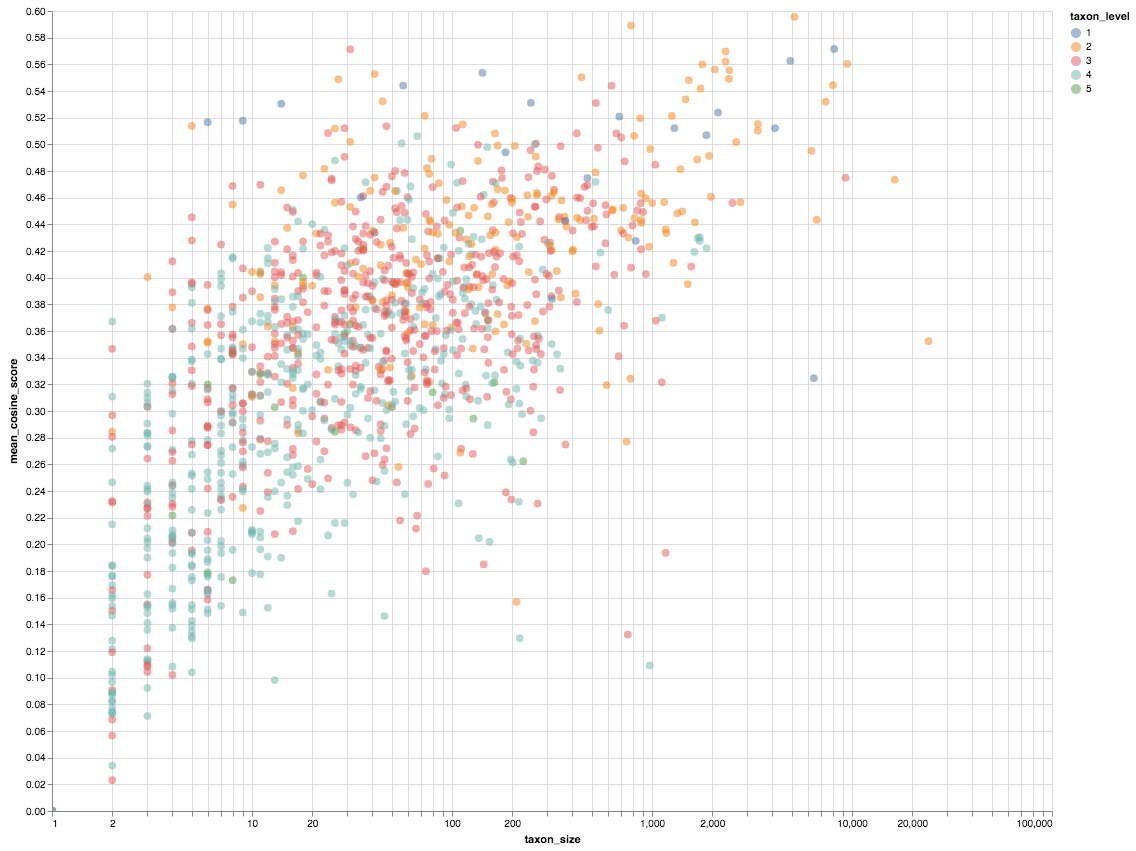

In [44]:
chart = alt.Chart(taxon_homogeneity_df).mark_circle(size=60).encode(
    alt.X('taxon_size:Q', scale=alt.Scale(type='log')),
    y='mean_cosine_score',
    color='taxon_level:N',
    opacity=alt.value(0.5),
    tooltip=['taxon_base_path'],
).properties(
    width=1000, height=800).interactive()

chart.save('taxon_homogeneity_big.html')
chart


### Looking at the relationship between taxon size and diversity
Is there a way of finding taxons with more diversity than expected , given size?

In [45]:
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(mean_per_level1['taxon_size'].values.reshape(-1, 1),
         mean_per_level1['mean_cosine_score'])

# Make predictions using the testing set
pred = regr.predict(mean_per_level1['taxon_size'].values.reshape(-1, 1))

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(
    mean_per_level1['taxon_size'], pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(mean_per_level1['taxon_size'], pred))

mean_per_level1['regression_pred'] = pred


Coefficients: 
 [0.00019362]
Mean squared error: 166967.82
Variance score: -1.92


/Users/ellieking/.pyenv/versions/3.6.4/envs/content-similarity-3.6.4/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


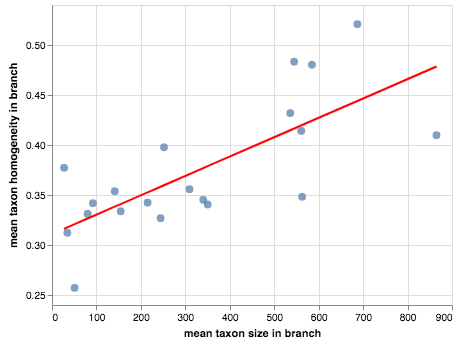

In [46]:
points = alt.Chart(mean_per_level1.reset_index()).mark_circle(size=60).encode(
        
    alt.X('taxon_size:Q', 
              axis=alt.Axis(title='mean taxon size in branch'), 
              scale=alt.Scale(zero=False)),
    alt.Y('mean_cosine_score:Q', 
              axis=alt.Axis(title='mean taxon homogeneity in branch'), 
              scale=alt.Scale(zero=False)),
        tooltip=['level1taxon:N'],    
    ).interactive()

regression_line = alt.Chart(mean_per_level1).mark_line(color ='red'
).encode(
    y='regression_pred',
    x='taxon_size:Q',
)

points + regression_line

the bigger the taxon, the more mixed it is. You'd expect this. So how do you find taxons that are excessively mixed, given size?

### Branch level

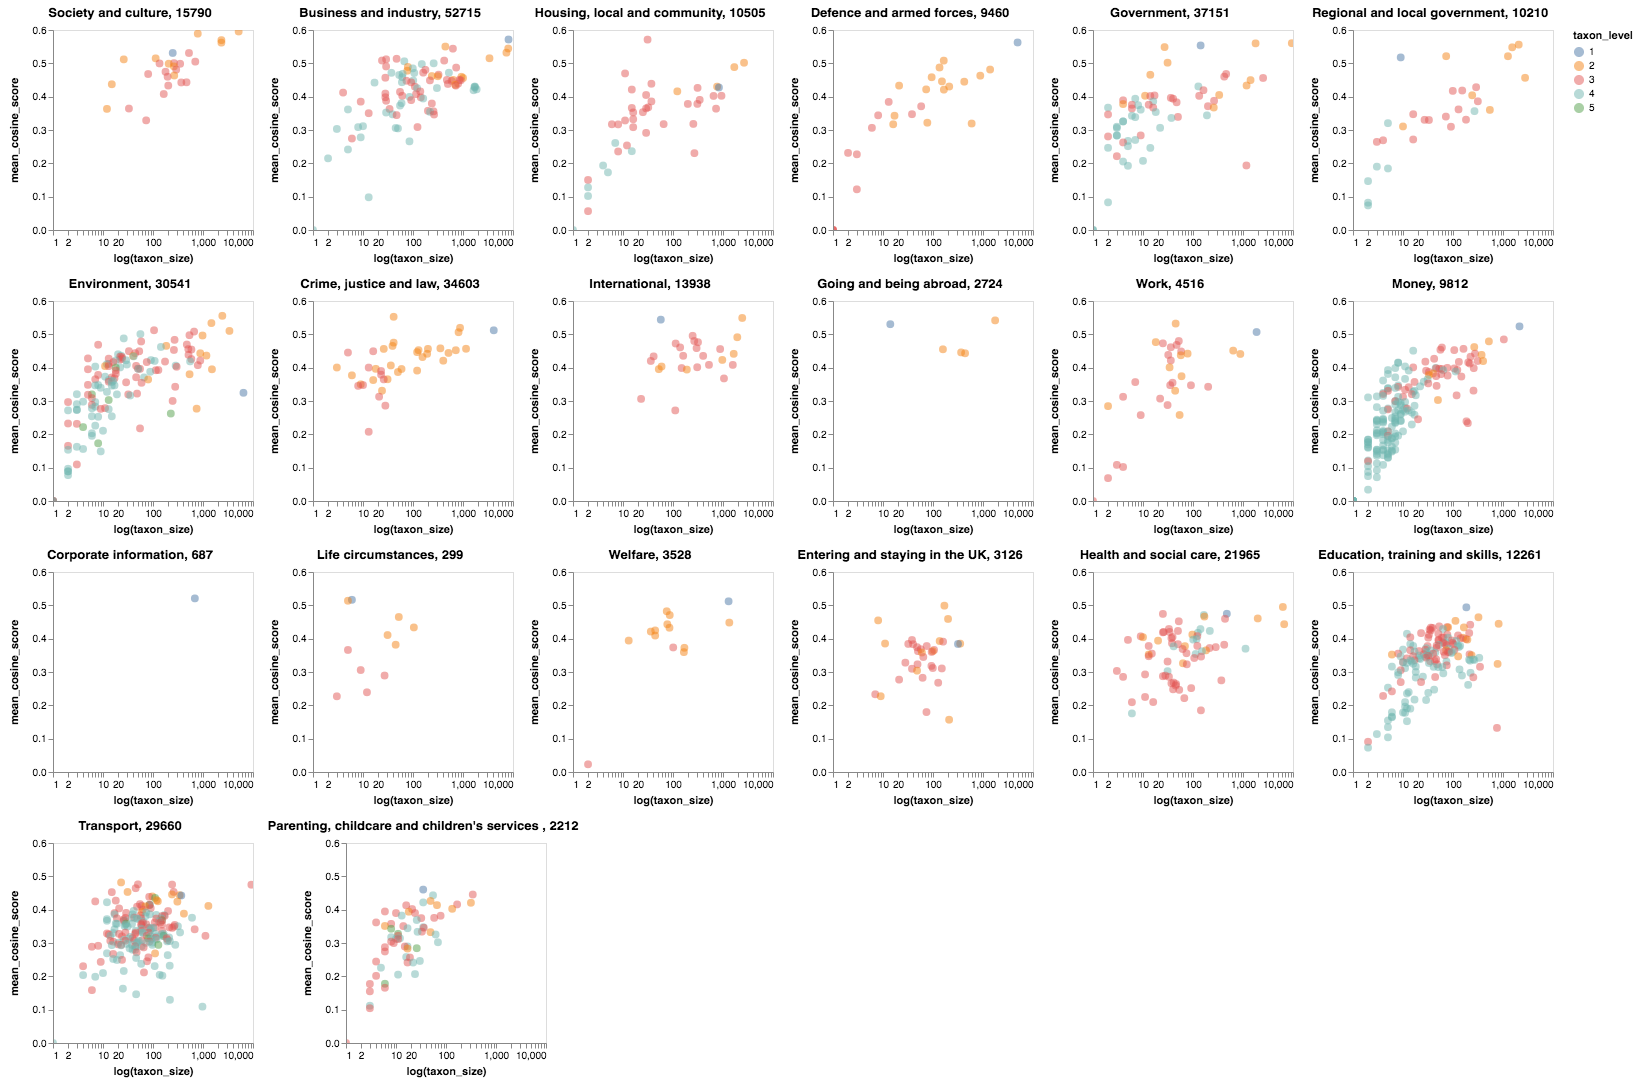

In [106]:
numcols = 6  # specify the number of columns you want
level1taxons = taxon_homogeneity_df['level1taxon'].unique(
)  # array of strings to use as your filters and titles

rows = alt.vconcat(data=taxon_homogeneity_df)
numrows = int(np.ceil(len(level1taxons) / numcols))
pointer = 0
for _ in range(numrows):
    row = level1taxons[pointer:pointer + numcols]
    cols = alt.hconcat()

    for a_chart in row:
        total_size = taxon_homogeneity_df[taxon_homogeneity_df['level1taxon'] ==
                                          a_chart]['taxon_size'].sum().astype(
                                              str)
        scatter = alt.Chart(taxon_homogeneity_df).mark_circle(size=60).encode(
            alt.X(
                'taxon_size:Q',
                scale=alt.Scale(type='log', domain=(1, 10000)),
                axis=alt.Axis(grid=False, title='log(taxon_size)')),
            alt.Y(
                'mean_cosine_score:Q',
                scale=alt.Scale(domain=(0, 0.6)),
                axis=alt.Axis(grid=False)),
            color='taxon_level:N',
            opacity=alt.value(0.5),
            tooltip=['taxon_base_path'],
        ).properties(
            width=1000, height=400).interactive().transform_filter(
                datum.level1taxon == a_chart).properties(
                    title=a_chart + ", " + total_size, height=200, width=200)

        #      # text labels
        #         annotation = alt.Chart(taxon_homogeneity_df).mark_text(
        #             align='left',
        #             baseline='middle',
        #             fontSize = 20,
        #             dx = 7
        #             ).encode(alt.X('taxon_size:Q',
        #                   scale=alt.Scale(type='log', domain=(1, 10000)),
        #                   axis=alt.Axis(grid=False)),
        #             alt.Y('mean_cosine_score:Q',
        #                   scale=alt.Scale(domain=(0, 0.6)),
        #                   axis=alt.Axis(grid=False)),
        #                      text='total_size'
        #                     ).transform_filter(datum.level1taxon == a_chart
        #                                       )

        both = scatter
        cols |= both

    rows &= cols
    pointer += numcols

rows.save('taxon_homogeneity_level1.html')
rows


In [108]:
numcols = 6  # specify the number of columns you want
level1taxons = taxon_homogeneity_df['level1taxon'].unique(
) 

business = taxon_homogeneity_df[taxon_homogeneity_df.level1taxon == 'Business and industry'].copy()

total_size = business['taxon_size'].sum().astype(
                                      str)
business_plot = alt.Chart(business).mark_circle(size=60).encode(
    alt.X(
        'taxon_size:Q',
        scale=alt.Scale(type='log', domain=(1, 10000)),
        axis=alt.Axis(grid=False, title='log(topic_size)')
    ),
    alt.Y(
        'mean_cosine_score:Q',
        scale=alt.Scale(domain=(0, 0.6)),
        axis=alt.Axis(grid=False, title='content diversity score')
    ), 
    color='taxon_level:N', 
    opacity=alt.value(0.5), 
    tooltip=['taxon_base_path']
).properties(
        title='Business & industry' + ", " + total_size).interactive()

business_plot.save('business.html', scale_factor=2.0)


level1(blue) and level2 (orange) taxons are further along x axis - stuff needs tagging deeper
blue and orange are further along the x and y axis with few red and green taxons - need more taxons at greater depth to split bigger mixed taxons
Taxons with high diversity: a few taxons are above 0.5 mean cosine, do these need splitting or does stuff in them need tagging deeper?


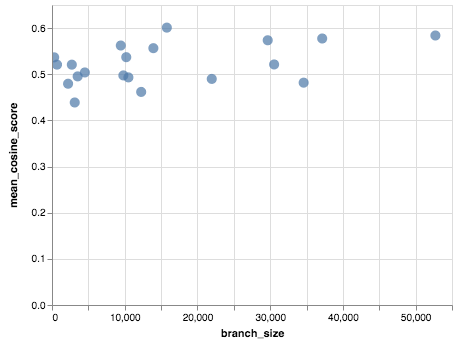

In [48]:
alt.Chart(branch_homogeneity_df).mark_circle(size=60).encode(
    x='branch_size',
    y='mean_cosine_score',
    tooltip=['branch'],    
    size=alt.value(100),
).interactive()

### Looking at the relationship between overall branch diversity and average taxon diversity within branch
Was trying to get a measure of 'efficient sorrting' but it never fully materialised.
Here are plots showing what I was creeping towards

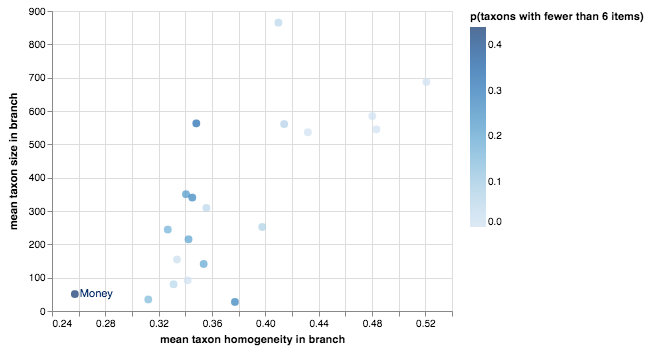

In [49]:
chart1  = alt.Chart(mean_per_level1.reset_index()).mark_circle(size=60).encode(
    alt.X('mean_cosine_score:Q', 
          axis=alt.Axis(title='mean taxon homogeneity in branch'), 
          scale=alt.Scale(zero=False)),
    alt.Y('taxon_size:Q', 
          axis=alt.Axis(title='mean taxon size in branch'), 
          scale=alt.Scale(zero=False)),
            color=alt.Color('fewer_than_or_equal_5items:Q', legend=alt.Legend(title="p(taxons with fewer than 6 items)")),
    tooltip=['level1taxon:N'],    
).interactive()

text1 = alt.Chart(mean_per_level1.reset_index()).mark_text(
    angle=0,
    align='left',
    baseline='middle',
    dx=5,
    clip=False,
#     limit=100,
).encode(
    alt.X('mean_cosine_score:Q', 
          axis=alt.Axis(title='mean taxon homogeneity in branch'), 
          scale=alt.Scale(zero=False)),
    alt.Y('taxon_size:Q', 
          axis=alt.Axis(title='mean taxon size in branch'), 
          scale=alt.Scale(zero=False)),
            color=alt.Color('fewer_than_or_equal_5items:Q', legend=alt.Legend(title="p(taxons with fewer than 6 items)")),
    text='level1taxon:N'
).transform_filter(
    datum.fewer_than_or_equal_5items>0.33
)

chart1 + text1

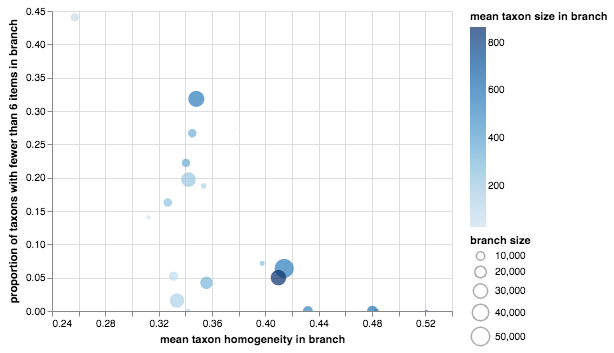

In [50]:
chart2 = alt.Chart(per_level1.reset_index()).mark_circle(size=60).encode(
    alt.X('mean_cosine_score_mean:Q', 
          axis=alt.Axis(title='mean taxon homogeneity in branch'), 
          scale=alt.Scale(zero=False)),
    alt.Y('fewer_than_or_equal_5items_mean:Q', 
          axis=alt.Axis(title='proportion of taxons with fewer than 6 items in branch'), 
          scale=alt.Scale(zero=False)),
    color=alt.Color('taxon_size_mean:Q', legend=alt.Legend(title="mean taxon size in branch")),
    size=alt.Size('taxon_size_sum:Q', legend=alt.Legend(title="branch size")),

    tooltip=['level1taxon:N'],    
).interactive()

text2 = alt.Chart(per_level1.reset_index()).mark_text(
    angle=0,
    align='left',
    baseline='middle',
    dx=5,
    clip=False,
#     limit=100,
).encode(
    alt.X('mean_cosine_score_mean:Q', 
          axis=alt.Axis(title='mean taxon homogeneity in branch'), 
          scale=alt.Scale(zero=False)),
    alt.Y('fewer_than_or_equal_5items_mean:Q', 
          axis=alt.Axis(), 
          scale=alt.Scale(zero=False)),
    text='level1taxon:N'
).transform_filter(
    datum.fewer_than_or_equal_5items>0.33
)

chart2 + text2

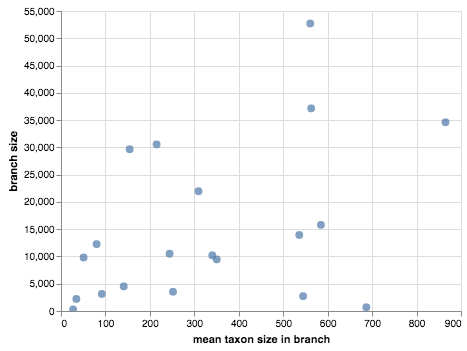

In [51]:
alt.Chart(per_level1.reset_index()).mark_circle(size=60).encode(
    alt.X('taxon_size_mean:Q', 
          axis=alt.Axis(title='mean taxon size in branch'), 
          scale=alt.Scale(zero=False)),
    alt.Y('taxon_size_sum:Q', 
          axis=alt.Axis(title='branch size'), 
          scale=alt.Scale(zero=False)),
    tooltip=['level1taxon:N'],    
).interactive()

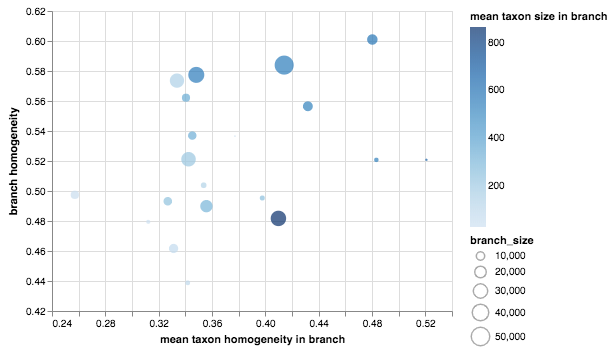

In [52]:
alt.Chart(branch_by_ave_taxon).mark_circle(size=60).encode(
    alt.X('mean_cosine_score_x:Q', 
          axis=alt.Axis(title='mean taxon homogeneity in branch'), 
          scale=alt.Scale(zero=False)),
    alt.Y('mean_cosine_score_y:Q', 
          axis=alt.Axis(title='branch homogeneity'), 
          scale=alt.Scale(zero=False)),
    tooltip=['branch:N'], 
    size = alt.Size('branch_size:Q'),
    color=alt.Color('taxon_size:Q', legend=alt.Legend(title="mean taxon size in branch"))

).interactive()


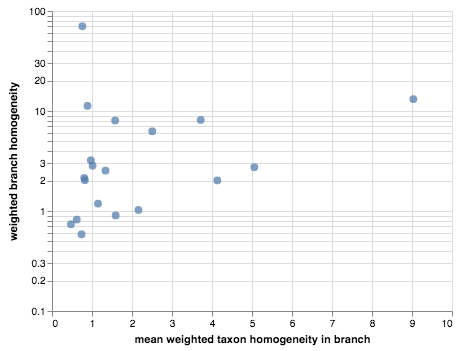

In [53]:
alt.Chart(branch_by_ave_taxon).mark_circle(size=60).encode(
    alt.X('weighted_score_taxon:Q', 
          axis=alt.Axis(title='mean weighted taxon homogeneity in branch'), 
          scale=alt.Scale(zero=False)),
    alt.Y('weighted_score:Q', 
          axis=alt.Axis(title='weighted branch homogeneity'), 
          scale=alt.Scale(type='log')),
    tooltip=['branch:N'], 
#     size = alt.Size('branch_size:Q'),
#     color=alt.Color('taxon_size:Q', legend=alt.Legend(title="mean taxon size in branch"))

).interactive()

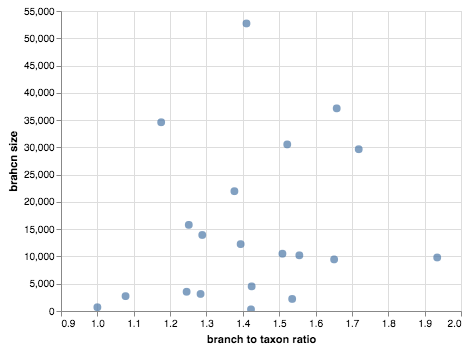

In [54]:
alt.Chart(branch_by_ave_taxon).mark_circle(size=60).encode(
    alt.X('branch_to_taxon_ratio:Q', 
          axis=alt.Axis(title='branch to taxon ratio'), 
          scale=alt.Scale(zero=False)),
    alt.Y('branch_size:Q', 
          axis=alt.Axis(title='brahcn size'), 
          scale=alt.Scale(zero=True)),
    tooltip=['branch:N'], 
#     size = alt.Size('branch_size:Q'),
#     color=alt.Color('taxon_size:Q', legend=alt.Legend(title="mean taxon size in branch"))

).interactive()

### Find problem content
items that are very different from the rest of the taxon. Use democracy as an example. It's small

In [55]:
democracy = embedded_sentences[labelled['taxon_id']=='95d06252-5d75-42fb-9c5c-038ab6b482e4']

In [56]:
democracy_distances = pairwise_distances(democracy, 
                           metric='cosine', 
                           n_jobs=-1)

In [57]:
democracy_distances.shape

(27, 27)

In [58]:
democracy_distances.mean()

0.54872733

In [59]:
democracy_distances.mean(axis=1).max()

0.72104305

In [60]:
democracy_distances_df = pd.DataFrame(democracy_distances)

In [61]:
democracy_distances_df['mean'] = democracy_distances.mean(axis=1)

In [62]:
democracy_distances_df[democracy_distances_df['mean']> democracy_distances.mean()].shape

(13, 28)

In [63]:
democracy_metadata = labelled[labelled['taxon_id']=='95d06252-5d75-42fb-9c5c-038ab6b482e4'].reset_index()

In [64]:
democracy_metadata[['base_path', 'title', 'description']][democracy_distances_df['mean']> 0.65]

base_path  \
5                          /when-do-the-clocks-change   
22  /government/speeches/foreign-secretarys-speech...   
25                                      /call-charges   

                                                title  \
5                          when do the clocks change?   
22  foreign secretary's speech at the united state...   
25                     call charges and phone numbers   

                                          description  
5   dates when the clocks go back or forward in 20...  
22  jeremy hunt called on like-minded countries to...  
25  call costs for 0800 0808 0845 0870 03 and othe...

### identifying clusters in taxons needing splitting
Used corportate as an example as everything is tagged to level1

In [8]:
corporate = embedded_sentences[labelled['taxon_id']=='a544d48b-1e9e-47fb-b427-7a987c658c14']

Try using principal component analysis to visualise clusters

In [9]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(corporate)

# corporate['pca-one'] = pca_result[:,0]
# corporate['pca-two'] = pca_result[:,1] 
# corporate['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(
    pca.explained_variance_ratio_))



Explained variation per principal component: [0.16539589 0.0632788  0.04710662]


In [10]:
pca_result[:,0].shape

(687,)

In [11]:
df = labelled[labelled['taxon_id']=='a544d48b-1e9e-47fb-b427-7a987c658c14'].copy()
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

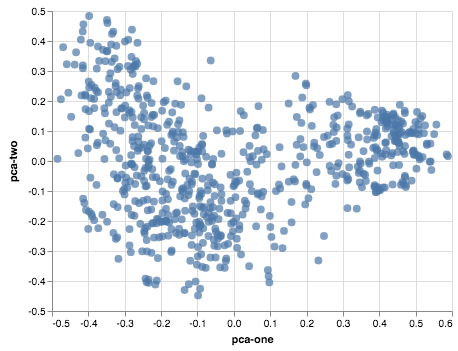

In [12]:
alt.Chart(df[['pca-one', 'pca-two', 'title']]).mark_circle(size=60).encode(
    alt.X('pca-one:Q'), 
    alt.Y('pca-two:Q'), 
    tooltip=['title:N'],
#     size = alt.Size('branch_size:Q'),
#     color=alt.Color('taxon_size:Q', legend=alt.Legend(title="mean taxon size in branch"))
).interactive()

Try using stocastic neighbour embeddings toreduce dimensions for visualisation:

Changin perplexity can make a big difference to results

In [13]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=7000)
tsne_results = tsne.fit_transform(corporate)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 687 samples in 0.010s...
[t-SNE] Computed neighbors for 687 samples in 0.346s...
[t-SNE] Computed conditional probabilities for sample 687 / 687
[t-SNE] Mean sigma: 0.249734
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.887566
[t-SNE] KL divergence after 3900 iterations: 1.020746
t-SNE done! Time elapsed: 15.260087966918945 seconds


In [14]:
df['x-tsne'] = tsne_results[:,0]
df['y-tsne'] = tsne_results[:,1]

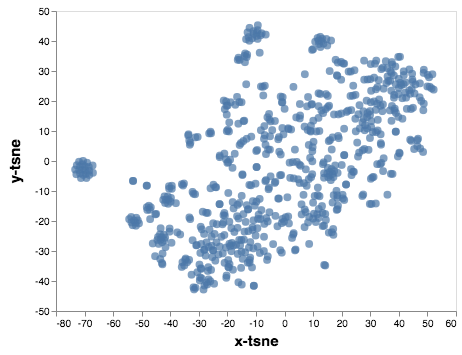

In [29]:
alt.Chart(df[['x-tsne', 'y-tsne', 'pca-one', 'pca-two', 'title']]).mark_circle(size=60).encode(
    alt.X('x-tsne:Q',
         axis=alt.Axis(grid=False)), 
    alt.Y('y-tsne:Q',
         axis=alt.Axis(grid=False)), 
    tooltip=['title:N']
#     size = alt.Size('branch_size:Q'),
#     color=alt.Color('taxon_size:Q', legend=alt.Legend(title="mean taxon size in branch"))
).configure_axis(
    titleFontSize=15).interactive()

In [30]:
alt.Chart(df[['x-tsne', 'y-tsne', 'pca-one', 'pca-two', 'title']]).mark_circle(size=60).encode(
    alt.X('x-tsne:Q',
         axis=alt.Axis(grid=False)), 
    alt.Y('y-tsne:Q',
         axis=alt.Axis(grid=False)), 
    tooltip=['title:N']
#     size = alt.Size('branch_size:Q'),
#     color=alt.Color('taxon_size:Q', legend=alt.Legend(title="mean taxon size in branch"))
).configure_axis(
    titleFontSize=15).save('/Users/ellieking/Documents/content-similarity/google-universal-encoder/corporate.html', scale_factor=4.0)

In [42]:
!pip install selenium

You are using pip version 19.0.2, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [31]:
alt.Chart(df[['x-tsne', 'y-tsne', 'pca-one', 'pca-two', 'title']]).mark_circle(size=60).encode(
    alt.X('x-tsne:Q',
         axis=alt.Axis(grid=False)), 
    alt.Y('y-tsne:Q',
         axis=alt.Axis(grid=False)), 
    tooltip=['title:N']
#     size = alt.Size('branch_size:Q'),
#     color=alt.Color('taxon_size:Q', legend=alt.Legend(title="mean taxon size in branch"))
).configure_axis(
    titleFontSize=15).save('/Users/ellieking/Documents/content-similarity/google-universal-encoder/corporate.png', scale_factor=4.0)

## Find concept overlap across taxons (potential merges)
start in money

This never really finished.

In [73]:
money = embedded_sentences[
    labelled[
        'level1taxon'
    ]=='Money'
]

In [74]:
money_df = labelled[
    labelled[
        'level1taxon'
    ]=='Money'
].copy()

In [75]:
time_start = time.time()
tsne_money = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=100)
tsne_results_money = tsne.fit_transform(money)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 9812 samples in 0.297s...
[t-SNE] Computed neighbors for 9812 samples in 79.648s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9812
[t-SNE] Computed conditional probabilities for sample 2000 / 9812
[t-SNE] Computed conditional probabilities for sample 3000 / 9812
[t-SNE] Computed conditional probabilities for sample 4000 / 9812
[t-SNE] Computed conditional probabilities for sample 5000 / 9812
[t-SNE] Computed conditional probabilities for sample 6000 / 9812
[t-SNE] Computed conditional probabilities for sample 7000 / 9812
[t-SNE] Computed conditional probabilities for sample 8000 / 9812
[t-SNE] Computed conditional probabilities for sample 9000 / 9812
[t-SNE] Computed conditional probabilities for sample 9812 / 9812
[t-SNE] Mean sigma: 0.216430
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.241844


KeyboardInterrupt: 

In [ ]:
money_df['x-tsne'] = tsne_results_money[:,0]
money_df['y-tsne'] = tsne_results_money[:,1]

In [ ]:
alt.data_transformers.enable('default', max_rows=None)
alt.Chart(
    money_df[
    [
        'x-tsne', 
         'y-tsne', 
         'title', 
         'taxon_base_path', 
         'taxon_id',
    ]
]
).mark_circle(size=60).encode(
    alt.X('x-tsne:Q'), 
    alt.Y('y-tsne:Q'), 
    tooltip=['title:N', 'taxon_base_path:N'],
#     size = alt.Size('branch_size:Q'),
    color=alt.Color('taxon_base_path:N', legend=alt.Legend(title="Taxon id"))
).interactive()

In [ ]:
money_df[['taxon_base_path', 'content_id']].groupby(['content_id', 'taxon_base_path'])

In [ ]:
# money_df.set_index(['taxon_base_path', 'content_id']).unstack('taxon_base_path')

money_df['idx'] = money_df.groupby('content_id').cumcount()
df = money_df.pivot(index='content_id',columns='idx')['taxon_base_path']
df2 = df.iloc[:, 0:2]
df2.columns = ['first', 'second']
mat = df2.groupby(['first', 'second']).size()
# mat.columns = mat.columns.droplevel(0)

In [ ]:
df3 = pd.DataFrame(mat).reset_index()
df3.columns = ['first', 'second', 'freq']

In [ ]:
chart = alt.Chart(df3).mark_rect().encode(
    x='first:O',
    y='second:O',
    color='freq:Q', 
    tooltip=['first:O','second:O']
)
chart.save('money_crosstab.html')
chart